In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error
import io
import base64

# Função para decodificar e carregar o conteúdo do arquivo CSV
def parse_contents(contents):
    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    df = pd.read_csv(io.StringIO(decoded.decode('utf-8')), header=None)
    return df



In [11]:
# Conteúdo do arquivo CSV (substitua pelo seu conteúdo codificado)
contents = r"C:\Users\camps pro\Documents\BOOTCAMP\10.Fazendo Benchmark de Series Temporais\monthly-milk-production-pounds-p.csv"


# Processar o arquivo CSV
df = pd.read_csv(contents, sep=';', header=None, names=['date', 'value'], index_col=0, parse_dates=True)
df.columns = ['value']
start_date = '2000-01-01'
end_date = '2013-12-31'
start_year, start_month, _ = start_date.split('-')
end_year, end_month, _ = end_date.split('-')
data = pd.Series(df['value'].values, 
                 index=pd.date_range(start=f'{start_year}-{start_month}-01', 
                                     end=f'{end_year}-{end_month}-01', freq='MS'))



C:\Users\camps pro\AppData\Local\Temp\ipykernel_4412\2270518745.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(contents, sep=';', header=None, names=['date', 'value'], index_col=0, parse_dates=True)


In [24]:
df = pd.read_csv(r"C:\Users\camps pro\Documents\BOOTCAMP\10.Fazendo Benchmark de Series Temporais\monthly-milk-production-pounds-p.csv", sep=';', header=None, names=['value'])
df.set_index(pd.date_range(start='2000-01-01', end='2013-12-01', freq='MS'), inplace=True)
data = df

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, Holt, ARIMA
from statsmodels.tsa.seasonal import STL

# Supondo que 'data' seja um DataFrame ou Series já definido
# Verificar se 'data' é um Series e converter para evitar problemas
if isinstance(data, pd.DataFrame):
    data = data.squeeze()

data = data.dropna()
# Dividir os dados em treino e teste
treino = data.iloc[:-24]
teste = data.iloc[-24:]

# Definir os métodos de previsão
forecast_methods = {
    'Naive': pd.Series(treino.iloc[-1], index=teste.index),
    'Mean': pd.Series([treino.mean()] * 24, index=teste.index),
    'Drift': pd.Series(np.linspace(treino.iloc[-1], treino.iloc[-1] + (treino.iloc[-1] - treino.iloc[0]) * 24 / (len(treino) - 1), 24), index=teste.index),
    'Holt': Holt(treino).fit(smoothing_level=0.8, smoothing_slope=0.2).forecast(24),
    'Holt Winter Additive': ExponentialSmoothing(treino, seasonal='add', seasonal_periods=12).fit().forecast(24),
    'Holt Winter Multiplicative': ExponentialSmoothing(treino, seasonal='mul', seasonal_periods=12).fit().forecast(24),
    'ARIMA': ARIMA(treino, order=(5,1,0)).fit().forecast(steps=24),
    
}



C:\Users\camps pro\AppData\Local\Temp\ipykernel_4412\862850190.py:23: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  'Holt': Holt(treino).fit(smoothing_level=0.8, smoothing_slope=0.2).forecast(24),
c:\Users\camps pro\anaconda3\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


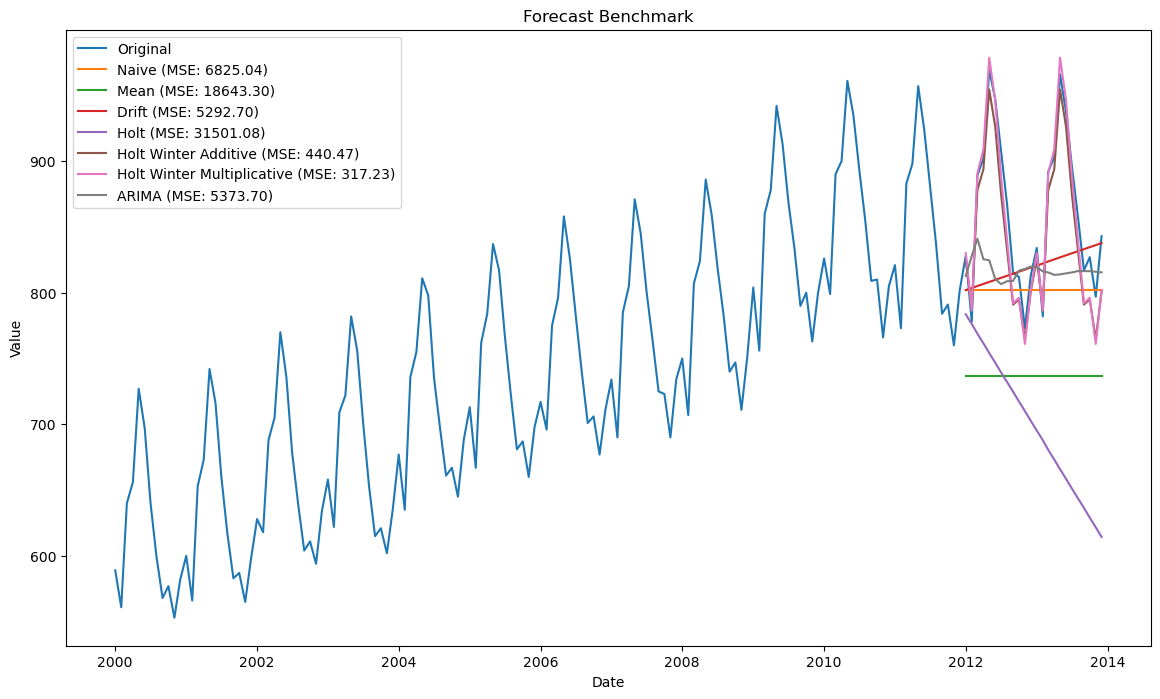

In [52]:
# Calcular MSE e armazenar resultados
results = {}
for method, forecast in forecast_methods.items():
    mse = mean_squared_error(teste, forecast)
    results[method] = {
        'mse': mse,
        'forecast': forecast
    }

# Plotar as previsões
plt.figure(figsize=(14, 8))
plt.plot(data, label='Original')

for method in results:
    plt.plot(results[method]['forecast'], label=f'{method} (MSE: {results[method]["mse"]:.2f})')

plt.legend()
plt.title('Forecast Benchmark')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()
